# Neural Network Implementation in PyTorch

This Jupyter notebook demonstrates a simple neural network implemented in PyTorch for regression tasks using a dataset loaded from a CSV file, which contained heart failure data after PCA implementation. The notebook covers data loading, preprocessing, model definition, training, and evaluation.

## Imports
We start by importing the necessary libraries:
- `pandas` for data manipulation and analysis.
- `torch`, `torch.nn`, and `torch.optim` for building and optimizing neural networks.
- `sklearn` for data preprocessing and splitting.
- `matplotlib` for plotting and visualizing the training process.



In [18]:

# Imports
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


## Data Loading and Inspection

In this section, we load the dataset from a CSV file and inspect the data to understand its structure and characteristics.

1. **Load CSV Data**: We use `pandas.read_csv` to load the data from a CSV file into a DataFrame.
2. **Inspect Data**: We print the first few rows of the data using `data.head()`, display statistical summaries using `data.describe()`, and check the data types of each column using `data.dtypes`.

This helps us understand the features and target variable, as well as the presence of any missing or categorical data.



In [19]:
# Load CSV data
data_path = './Data/pca_output.csv'
data = pd.read_csv(data_path)

# Inspect data
print(data.head())
print(data.describe())
print(data.dtypes)


        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -2.955159 -1.560260  0.097974  0.896793  0.700994 -0.245900  0.867275   
1 -0.770247  1.315624 -1.927614 -2.148217 -0.907282  1.481883  0.116760   
2 -1.908705 -0.592362  1.159538  2.901140 -1.311335 -0.191523 -0.039797   
3  2.000908  0.703153 -3.283777  0.089905  0.117482  0.185970 -0.285569   
4 -1.913519 -1.106466  0.781337 -1.146080 -0.739537  1.529513 -0.887756   

        PC8  
0 -0.856372  
1  0.562671  
2  0.234949  
3  0.713701  
4 -0.800937  
                PC1           PC2           PC3         PC4           PC5  \
count  7.460000e+02  7.460000e+02  7.460000e+02  746.000000  7.460000e+02   
mean   7.619761e-17  7.619761e-17  7.619761e-17    0.000000  1.904940e-17   
std    2.305208e+00  1.421294e+00  1.353029e+00    1.193318  1.151826e+00   
min   -4.147973e+00 -2.339167e+00 -3.660851e+00   -2.910956 -3.582033e+00   
25%   -2.119389e+00 -1.289077e+00 -9.954078e-01   -0.778808 -6.493432e-01   
50%

## Data Preprocessing

Next, we preprocess the data to prepare it for training the neural network. This involves several steps:

1. **One-Hot Encode Categorical Features**: We use `OneHotEncoder` to convert categorical features into numerical values.
2. **Concatenate Numerical and Encoded Categorical Data**: We combine the numerical features with the one-hot encoded categorical features.
3. **Split Data into Training and Testing Sets**: We use `train_test_split` to split the data into training and testing sets.
4. **Standardize the Data**: We scale the features using `StandardScaler` to standardize the data.
5. **Convert Data to PyTorch Tensors**: Finally, we convert the NumPy arrays into PyTorch tensors, which are required for training the neural network.

This ensures that our data is in the correct format and scale for the neural network to learn effectively.



In [20]:
# Assuming the last column is the target and others are features
target_column = data.columns[-1]
categorical_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = data.select_dtypes(include=['number']).columns.tolist()
numerical_columns.remove(target_column)

# One-Hot Encode categorical columns
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_categorical_data = encoder.fit_transform(data[categorical_columns])

# Concatenate numerical and encoded categorical data
X = pd.concat([data[numerical_columns], pd.DataFrame(encoded_categorical_data)], axis=1).values
y = data[target_column].values

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


## Creating Datasets and DataLoaders

We create PyTorch datasets and dataloaders for batch processing. This helps in efficiently feeding data to the neural network during training.

1. **Create TensorDatasets**: We create `TensorDataset` objects for the training and testing data.
2. **Create DataLoaders**: We create `DataLoader` objects for batch processing, which shuffle the training data and prepare batches of data for the model.

DataLoaders make it easy to iterate over the data in mini-batches, which is crucial for efficient training and gradient descent optimization.


In [21]:
# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


## Defining the Neural Network

Here, we define a simple neural network class in PyTorch. This neural network consists of three fully connected layers with ReLU activation functions.

1. **Define the Network Structure**: We create a class `SimpleNN` that inherits from `nn.Module`.
2. **Initialize Layers**: In the `__init__` method, we define three fully connected layers (`fc1`, `fc2`, and `fc3`).
3. **Forward Pass**: In the `forward` method, we define the forward pass through the network, applying the ReLU activation function after the first two layers.

This neural network takes input features, processes them through the layers, and outputs a single value for regression tasks.


In [22]:
# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
model = SimpleNN(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## Training the Neural Network

In this section, we train the neural network. We define the training loop, specify the loss function, and use the Adam optimizer. We also record the training and testing losses at each epoch.

1. **Initialize Model, Loss Function, and Optimizer**: We initialize the neural network, define the Mean Squared Error (MSE) loss function, and use the Adam optimizer.
2. **Training Loop**: We iterate over the number of epochs, and for each epoch:
   - Set the model to training mode.
   - Iterate over the training data in batches.
   - Perform forward pass, compute loss, backpropagate, and update weights.
   - Record the training loss.
   - Evaluate the model on the test set and record the test loss.

We print the training and test losses for each epoch to monitor the training process.


In [23]:
# Training loop with recording losses
num_epochs = 50
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_losses.append(running_loss / len(train_loader))
    
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            test_loss += loss.item()
    
    test_losses.append(test_loss / len(test_loader))
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}')


Epoch 1/50, Train Loss: 0.9781980953718487, Test Loss: 1.3023361325263978
Epoch 2/50, Train Loss: 0.912721640185306, Test Loss: 1.2704842567443848
Epoch 3/50, Train Loss: 0.8509566376083776, Test Loss: 1.2319246053695678
Epoch 4/50, Train Loss: 0.8007708568322031, Test Loss: 1.1868826150894165
Epoch 5/50, Train Loss: 0.742168526900442, Test Loss: 1.1434610962867737
Epoch 6/50, Train Loss: 0.6650570348689431, Test Loss: 1.081934881210327
Epoch 7/50, Train Loss: 0.5800544964639764, Test Loss: 1.027490258216858
Epoch 8/50, Train Loss: 0.518210442442643, Test Loss: 0.9743427872657776
Epoch 9/50, Train Loss: 0.4714731158394563, Test Loss: 0.9468925952911377
Epoch 10/50, Train Loss: 0.41775025662622955, Test Loss: 0.9289019644260407
Epoch 11/50, Train Loss: 0.39563749103169693, Test Loss: 0.9032749235630035
Epoch 12/50, Train Loss: 0.37720006861184774, Test Loss: 0.9016921937465667
Epoch 13/50, Train Loss: 0.350497747722425, Test Loss: 0.872247838973999
Epoch 14/50, Train Loss: 0.33421569984

## Evaluating and Plotting Results

Finally, we evaluate the neural network by plotting the training and validation losses over epochs to visualize the model's performance.

1. **Plot Losses**: We use `matplotlib` to create a plot showing the training and validation losses over the epochs.
2. **Interpret Results**: By examining the plot, we can see how well the model is learning and if it's overfitting or underfitting.

This helps us understand the training dynamics and make necessary adjustments to the model or training procedure.


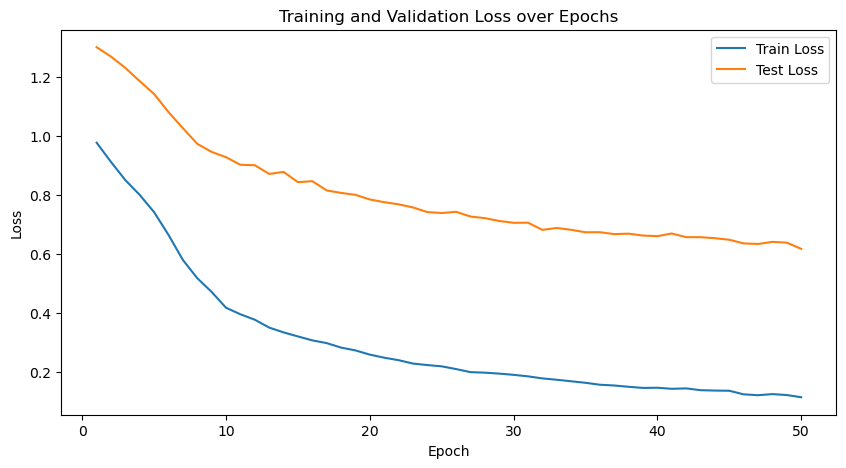

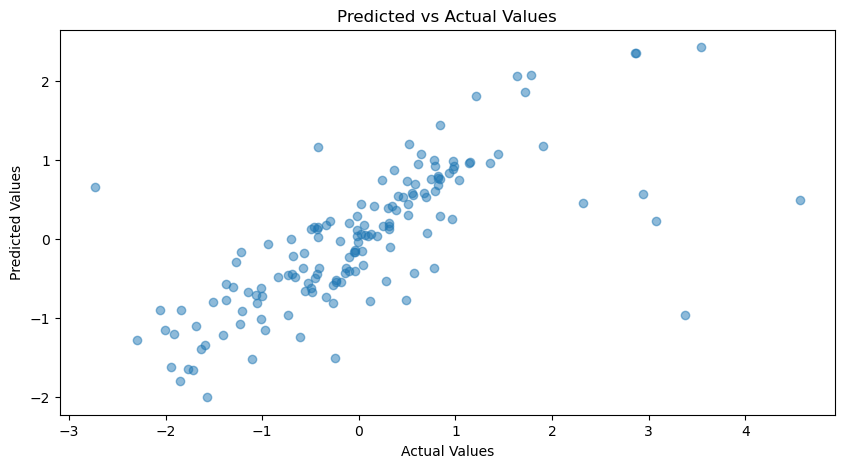

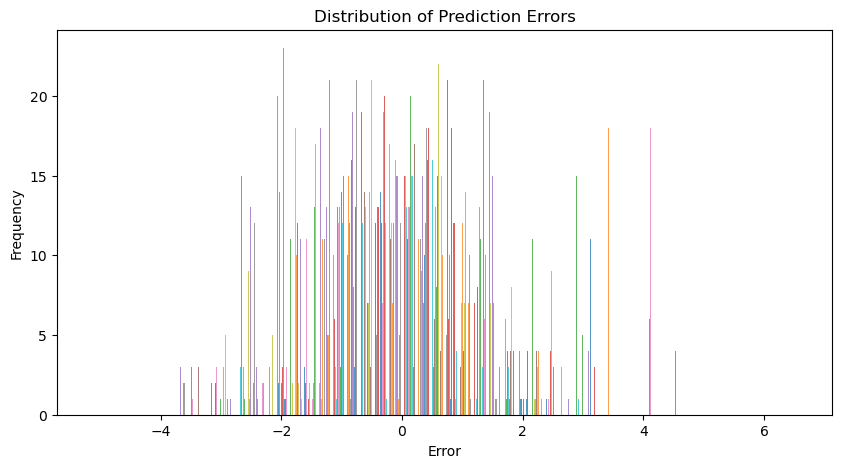

In [24]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# Predicted vs. Actual Values Plot
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()

plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()

# Distribution of Errors Plot
plt.figure(figsize=(10, 5))
plt.hist(y_test - y_pred, bins=50, alpha=0.75)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()
